<a href="https://colab.research.google.com/github/Tapanmittal13/Data_Science/blob/master/Assignment_7_B_ENAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Steps followed :**

**As instructed did the following changes to Assignment 6_A**

1.   As earlier few layers do Normal Convolution
2.   Added Spatially Separable Convolution  (Conv2d(x, (3,1)) followed by Conv2D(x,(3,1))
3.   Added Separable Convolution
4.   Added Grouped Convolution (use 3x3, 5x5 only)
5.   Added Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2) 

Then trained for 50 epochs

**All this resulted in importing few dependent packages and changing from sequential to functional API.**

**Achieving certain accuracy is not on my mind in this particular assignment, just wanted to see how advanced convolutions are 
used. But I was expecting lesser number of parameters here but then 5x5 kernel was used for first time, which resulted in more params and best
accuracy didn't change much from assignment 6_A**

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

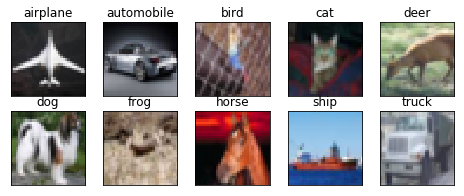

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [0]:
from keras import regularizers
#from keras.layers.merge import add
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers import  Conv2D, Input,SeparableConv2D,Lambda
import tensorflow as tf

# Define the model
#using Functional API

weight_decay=0.001
input=Input(shape=(32, 32, 3))

#Layer1 #Depthwise Conv 5x5
Layer1=SeparableConv2D(32,(5,5),border_mode='same',name='Sep_conv_1')(input)
Layer1=Activation('relu')(Layer1)
Layer1=BatchNormalization()(Layer1)

skip_connection_Layer1 = Layer1

#Layer2 #Normal Conv 5x5
Layer2=Conv2D(32,(5,5),border_mode='same',name='normal_conv_1')(Layer1) 
Layer2=Activation('relu')(Layer2)
Layer2=BatchNormalization()(Layer2)

skip_connection_Layer2 = Layer2

#Layer3 #Normal Conv 5x5
Layer3=Conv2D(32,(5,5),border_mode='same',name='normal_conv_2')(Layer2) 
Layer3=Activation('relu')(Layer3)
Layer3=BatchNormalization()(Layer3)

skip_connection_Layer3 = Layer3

#Concate_1
concate_1=concatenate([Layer1, Layer3])

#Layer4 #Depthwise Conv 5x5 
Layer4=SeparableConv2D(32,(5,5),border_mode='same',name='Sep_conv_2')(concate_1)
Layer4=Activation('relu')(Layer4)
Layer4=BatchNormalization()(Layer4)

skip_connection_Layer4 = Layer4

#Concate_2
concate_2=concatenate([Layer1,Layer4])

#Maxpooling1
maxpool_1=MaxPooling2D(pool_size=(2, 2))(concate_2)

#space_to_depth
skip_connection_Layer1 = Lambda(space_to_depth_x2)(skip_connection_Layer1)
skip_connection_Layer2 = Lambda(space_to_depth_x2)(skip_connection_Layer2)
skip_connection_Layer3 = Lambda(space_to_depth_x2)(skip_connection_Layer3)
skip_connection_Layer4 = Lambda(space_to_depth_x2)(skip_connection_Layer4)

#Layer5 #Depthwise Conv 3x3
Layer5=SeparableConv2D(32,(3,3),border_mode='same',name='Sep_conv_3')(maxpool_1)
Layer5=Activation('relu')(Layer5)
Layer5=BatchNormalization()(Layer5)

skip_connection_Layer5 = Layer5

#Concate_3
concate_3=concatenate([skip_connection_Layer1,skip_connection_Layer4, Layer5])

#Layer6 #Normal Conv 5x5
Layer6=Conv2D(64,(5,5),border_mode='same',name='normal_conv_3')(concate_3)
Layer6=Activation('relu')(Layer6)
Layer6=BatchNormalization()(Layer6)

skip_connection_Layer6 = Layer6

#Concate_4
concate_4=concatenate([ skip_connection_Layer3,skip_connection_Layer4,Layer5,Layer6])



#Layer7 #Depthwise Conv 3x3
Layer7=SeparableConv2D(128,(3,3),border_mode='same',name='Sep_conv_4')(concate_4)
Layer7=Activation('relu')(Layer7)
Layer7=BatchNormalization()(Layer7)

skip_connection_Layer7 = Layer7

#Concate_5
concate_5=concatenate([skip_connection_Layer1,skip_connection_Layer3,skip_connection_Layer4,Layer5,Layer6,Layer7])

#Layer8 #Depthwise Conv 5x5
Layer8=SeparableConv2D(32,(5,5),border_mode='same',name='Sep_conv_5')(concate_5)
Layer8=Activation('relu')(Layer8)
Layer8=BatchNormalization()(Layer8)

skip_connection_Layer8 = Layer8

#concate_6
concate_6=concatenate([skip_connection_Layer1,skip_connection_Layer4,Layer5,Layer7,Layer8])

#Maxpooling2
maxpool_2=MaxPooling2D(pool_size=(2, 2))(concate_6)

#space_to_depth
skip_connection_Layer1_1 = Lambda(space_to_depth_x2)(skip_connection_Layer1)
skip_connection_Layer2_2 = Lambda(space_to_depth_x2)(skip_connection_Layer2)
skip_connection_Layer3_3 = Lambda(space_to_depth_x2)(skip_connection_Layer3)
skip_connection_Layer4_4 = Lambda(space_to_depth_x2)(skip_connection_Layer4)
skip_connection_Layer5 = Lambda(space_to_depth_x2)(skip_connection_Layer5)
skip_connection_Layer6 = Lambda(space_to_depth_x2)(skip_connection_Layer6)
skip_connection_Layer7 = Lambda(space_to_depth_x2)(skip_connection_Layer7)
#skip_connection_Layer8 = Lambda(space_to_depth_x2)(skip_connection_Layer8)

#concate_7
concate_7=concatenate([maxpool_2, skip_connection_Layer6])

#Layer9 #normal Conv 5x5
Layer9=Conv2D(128,(5,5),border_mode='same',name='normal_conv_4')(concate_7)
Layer9=Activation('relu')(Layer9)
Layer9=BatchNormalization()(Layer9)

#skip_connection_Layer9 = Layer9



#Concate_8
concate_8=concatenate([skip_connection_Layer1_1,skip_connection_Layer2_2,skip_connection_Layer4_4,skip_connection_Layer7,Layer9])

#Layer10 #Depthwise Conv 5x5
Layer10=SeparableConv2D(32,(5,5),border_mode='same',name='Sep_conv_6')(concate_8)
Layer10=Activation('relu')(Layer10)
Layer10=BatchNormalization()(Layer10)

#skip_connection_Layer10 = Layer10

#Concate_9
concate_9=concatenate([skip_connection_Layer2_2, skip_connection_Layer3_3,skip_connection_Layer5,Layer10])

#Layer11 #Normal Conv 3x3
Layer11=Conv2D(32,(3,3),border_mode='same',name='normal_conv_5')(concate_9)
Layer11=Activation('relu')(Layer11)
Layer11=BatchNormalization()(Layer11)

#skip_connection_Layer11 = Layer11

#concate_10
concate_10=concatenate([skip_connection_Layer3_3,skip_connection_Layer4_4,skip_connection_Layer5,skip_connection_Layer7,Layer10,Layer11])

#Layer12 #Depthwise Conv 5x5 
Layer12=SeparableConv2D(64,(5,5),border_mode='same',name='Sep_conv_7')(concate_10)
Layer12=Activation('relu')(Layer12)
Layer12=BatchNormalization()(Layer12)

#skip_connection_Layer12 = Layer12

#Concate_11
concate_11=concatenate([skip_connection_Layer4_4,skip_connection_Layer7,Layer10,Layer11,Layer12])


Layer13=Conv2D(10,(8,8),name='Sort_of_GAP')(concate_11)

flatten=Flatten()(Layer13)

output=Activation('softmax')(flatten);
 
  
model = Model(inputs=[input], outputs=[output])
          
# Compile the model
  
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (5, 5), name="Sep_conv_1", padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), name="normal_conv_1", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), name="normal_conv_2", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (5, 5), name="Sep_conv_2", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (3, 3), name="Sep_conv_3", padding="same")`

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
Sep_conv_1 (SeparableConv2D)    (None, 32, 32, 32)   203         input_2[0][0]                    
__________________________________________________________________________________________________
activation_14 (Activation)      (None, 32, 32, 32)   0           Sep_conv_1[0][0]                 
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 32, 32, 32)   128         activation_14[0][0]              
__________________________________________________________________________________________________
normal_con

In [0]:
import numpy as np
from keras.callbacks import Callback
class GetBest(Callback):
    """Get the best model at the end of training.
	# Arguments
        monitor: quantity to monitor.
        verbose: verbosity mode, 0 or 1.
        mode: one of {auto, min, max}.
            The decision
            to overwrite the current stored weights is made
            based on either the maximization or the
            minimization of the monitored quantity. For `val_acc`,
            this should be `max`, for `val_loss` this should
            be `min`, etc. In `auto` mode, the direction is
            automatically inferred from the name of the monitored quantity.
        period: Interval (number of epochs) between checkpoints.
	# Example
		callbacks = [GetBest(monitor='val_acc', verbose=1, mode='max')]
		mode.fit(X, y, validation_data=(X_eval, Y_eval),
                 callbacks=callbacks)
    """

    def __init__(self, monitor='val_loss', verbose=0,
                 mode='auto', period=1):
        super(GetBest, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.period = period
        self.best_epochs = 0
        self.epochs_since_last_save = 0

        if mode not in ['auto', 'min', 'max']:
            warnings.warn('GetBest mode %s is unknown, '
                          'fallback to auto mode.' % (mode),
                          RuntimeWarning)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
            self.best = np.Inf
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = -np.Inf
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = -np.Inf
            else:
                self.monitor_op = np.less
                self.best = np.Inf
                
    def on_train_begin(self, logs=None):
        self.best_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            #filepath = self.filepath.format(epoch=epoch + 1, **logs)
            current = logs.get(self.monitor)
            if current is None:
                warnings.warn('Can pick best model only with %s available, '
                              'skipping.' % (self.monitor), RuntimeWarning)
            else:
                if self.monitor_op(current, self.best):
                    if self.verbose > 0:
                        print('\nEpoch %05d: %s improved from %0.5f to %0.5f,'
                              ' storing weights.'
                              % (epoch + 1, self.monitor, self.best,
                                 current))
                    self.best = current
                    self.best_epochs = epoch + 1
                    self.best_weights = self.model.get_weights()
                else:
                    if self.verbose > 0:
                        print('\nEpoch %05d: %s did not improve' %
                              (epoch + 1, self.monitor))            
                    
    def on_train_end(self, logs=None):
        if self.verbose > 0:
            print('Using epoch %05d with %s: %0.5f' % (self.best_epochs, self.monitor,
                                                       self.best))
        self.model.set_weights(self.best_weights)

In [0]:
callbacks = [GetBest(monitor='val_acc', verbose=1, mode='max')]

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

W0620 05:24:54.941858 140446167140224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,featurewise_center=True, featurewise_std_normalization=True)
testgen=ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = datagen.flow(test_features, test_labels),validation_steps=len(test_features)//128,callbacks=callbacks,verbose=1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., validation_steps=78, callbacks=[<__main__..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':
W0620 05:24:55.402953 140446167140224 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorfl

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


390/390 [==============================] - 56s 143ms/step - loss: 2.1752 - acc: 0.5004 - val_loss: 1.1938 - val_acc: 0.5865

Epoch 00001: val_acc improved from -inf to 0.58654, storing weights.
Epoch 2/100
390/390 [==============================] - 52s 133ms/step - loss: 0.9211 - acc: 0.6820 - val_loss: 1.1222 - val_acc: 0.6306

Epoch 00002: val_acc improved from 0.58654 to 0.63061, storing weights.
Epoch 3/100
390/390 [==============================] - 51s 130ms/step - loss: 0.6219 - acc: 0.7852 - val_loss: 1.1882 - val_acc: 0.6458

Epoch 00003: val_acc improved from 0.63061 to 0.64583, storing weights.
Epoch 4/100
390/390 [==============================] - 51s 130ms/step - loss: 0.3914 - acc: 0.8655 - val_loss: 1.4050 - val_acc: 0.6418

Epoch 00004: val_acc did not improve
Epoch 5/100
390/390 [==============================] - 51s 131ms/step - loss: 0.2588 - acc: 0.9105 - val_loss: 1.7106 - val_acc: 0.6302

Epoch 00005: val_acc did not improve
Epoch 6/100
390/390 [===================

Model took 5086.57 seconds to train


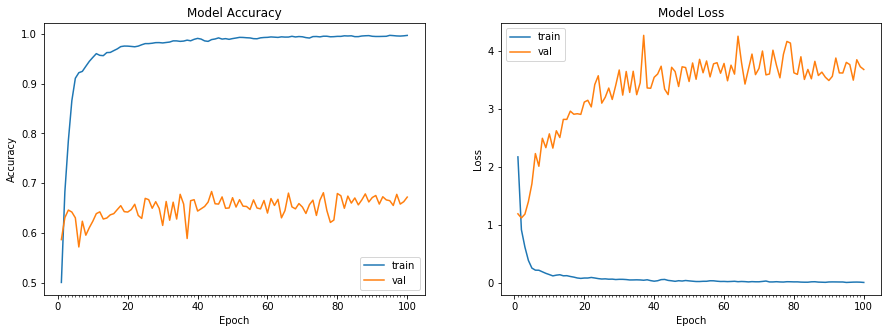

Accuracy on test data is: 66.85


In [0]:
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))